# This notebook tests out different values of perplexity for the visualization fo final layer of resnet_v1_50 applied to Diabetic_Retinopathy_Detection

The perplexity is related to the number of nearest neighbors that is used in other manifold learning algorithms. A larger perplexity takes more nearest neighbours in consideration. According to https://distill.pub/2016/misread-tsne/ the perplexity is the most hyperparameter to tune when optimizing the 
t-sne fit. thus this notebook is for investigating different values of this parameter onto our problem.

The values of perplexity analyzed are: 2, 5, 10, 30, 50, 80, 100, 200

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from datetime import datetime
import math
import time

import numpy as np
import tensorflow as tf

%run transfer.py
#import t_sne
#import evaluation_functions as ef

from time import time
import os

import matplotlib.pyplot as plt
from matplotlib import offsetbox
from sklearn import (manifold)
from sklearn.preprocessing import scale

train_dir = '/home/olle/PycharmProjects/Diabetic_Retinopathy_Detection/data/train'
eval_dir = '/home/olle/PycharmProjects/Diabetic_Retinopathy_Detection/data/validation'
eval_data = 'test'
checkpoint_dir = '/home/olle/PycharmProjects/Diabetic_Retinopathy_Detection/output/drd_train'
num_examples = 1000
batch_size = 10

In [2]:
# Scale and visualize the embedding vectors
def plot_embedding(X_tsne,images, labels, iter,  title=None):
    '''

    :param X_tsne:
    :param images:
    :param labels:
    :param iter:
    :param title:
    :return:
    '''
    x_min, x_max = np.min(X_tsne, 0), np.max(X_tsne, 0)
    X_tsne = (X_tsne - x_min) / (x_max - x_min)

    # change main figure size
    fig = plt.figure(figsize=(10,10))

    # change sub plot size
    ax = fig.add_subplot(1,1,1)
    for i in range(X_tsne.shape[0]):
        plt.text(X_tsne[i, 0], X_tsne[i, 1], str(labels[i]),
                 color=plt.cm.Set1(labels[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 15})

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(X_tsne.shape[0]):
            dist = np.sum((X_tsne[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X_tsne[i]]]
            # imagebox = offsetbox.AnnotationBbox(
            #     offsetbox.OffsetImage(images[i], cmap=plt.cm.gray_r),
            #     X_tsne[i])
            # ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        fig = plt.suptitle(title, fontsize=30)
    plt.show()


def t_sne_fit(logits, perplexity):
    # t-SNE embedding of the digits dataset
    print("Computing t-SNE embedding")
    tsne = manifold.TSNE(n_components=2,perplexity=perplexity, init='pca', random_state=0)
    t0 = time()

    X_tsne = tsne.fit_transform(logits)

    print("time elapsed:{}".format(time() - t0))
    return(X_tsne)

In [3]:
with tf.Graph().as_default() as g:
    # Get images and labels for CIFAR-10.
    eval_data == 'test'

    images, labels = inputs(eval_data=eval_data)

    # Build a Graph that computes the logits predictions from the
    # inference model.
    #logits = transfer.inference(images, FLAGS.n_residual_blocks)
    logits = inference2(images)
    # Calculate predictions.
    top_k_op = tf.nn.in_top_k(logits, labels, 1)
    pred = tf.cast(tf.argmax(logits, axis=1), tf.int32)

    # Restore the moving average version of the learned variables for eval.
    variable_averages = tf.train.ExponentialMovingAverage(
            MOVING_AVERAGE_DECAY)
    variables_to_restore = variable_averages.variables_to_restore()
    saver = tf.train.Saver(variables_to_restore)
    
    sess = tf.Session()
    ckpt = tf.train.get_checkpoint_state(checkpoint_dir)
    if ckpt and ckpt.model_checkpoint_path:
        print(ckpt.model_checkpoint_path)
        # Restores from checkpoint
        saver.restore(sess, ckpt.model_checkpoint_path)
        # Assuming model_checkpoint_path looks something like:
        #   /my-favorite-path/cifar10_train/model.ckpt-0,
        # extract global_step from it.
        global_step = ckpt.model_checkpoint_path.split('/')[-1].split('-')[-1]

    #lists to append results for visualizations
    final_layer = []
    class_pred = []
    class_labels = []
    # Start the queue runners.
    coord = tf.train.Coordinator()
    threads = []
    for qr in tf.get_collection(tf.GraphKeys.QUEUE_RUNNERS):
        threads.extend(qr.create_threads(sess, coord=coord, daemon=True,
                                         start=True))

    num_iter = int(math.ceil(num_examples / batch_size))
    true_count = 0  # Counts the number of correct predictions.
    total_sample_count = num_iter * batch_size
    step = 0
    while step < num_iter and not coord.should_stop():
        predictions, f_layer, cls_labels, cls_prediction = sess.run([top_k_op,logits, labels, pred])
        #book keep prediction, logits, labels
        class_pred.append(cls_prediction)
        final_layer.append(f_layer)
        class_labels.append(cls_labels)


        true_count += np.sum(predictions)
        step += 1

    # Compute precision @ 1.
    precision = true_count / total_sample_count
    print('%s: precision @ 1 = %.3f' % (datetime.now(), precision))
    #convert bookkeeping to numpy for helper function
    class_labels  = np.concatenate(class_labels, axis=0 )
    final_layer = np.concatenate(final_layer, axis=0)
    class_pred = np.concatenate(class_pred, axis=0 ).reshape(num_examples,1)


record bytes:::::  Tensor("Reshape:0", shape=(256, 256, 3), dtype=uint8)
Instructions for updating:
keep_dims is deprecated, use keepdims instead
/home/olle/PycharmProjects/Diabetic_Retinopathy_Detection/output/drd_train/model.ckpt-25200
INFO:tensorflow:Restoring parameters from /home/olle/PycharmProjects/Diabetic_Retinopathy_Detection/output/drd_train/model.ckpt-25200
2018-04-11 15:05:42.614930: precision @ 1 = 0.745


Computing t-SNE embedding
time elapsed:11.858025074


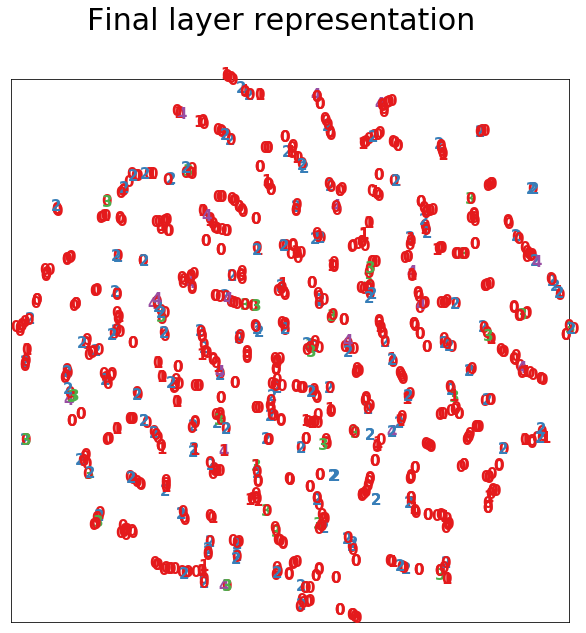

In [8]:
# here insert the TSNET visualization
plot_embedding(t_sne_fit(final_layer, 2), sess.run(images),
                           class_labels,
                           iter, title= "Final layer representation")

Computing t-SNE embedding
time elapsed:12.3156430721


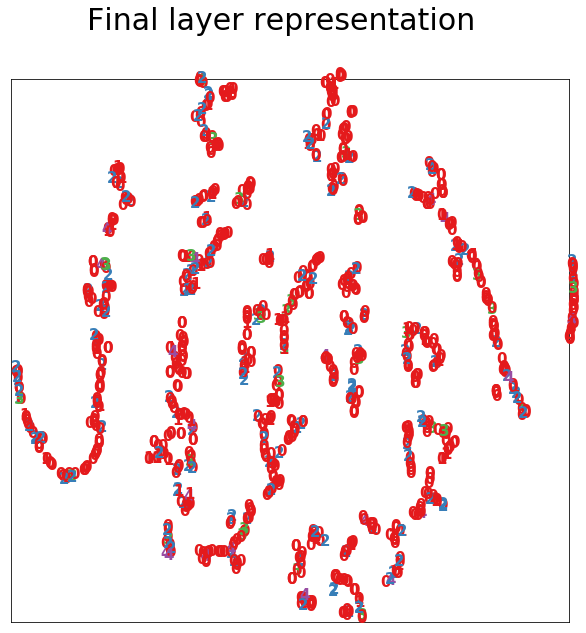

In [10]:
# here insert the TSNET visualization
plot_embedding(t_sne_fit(final_layer, 5), sess.run(images),
                           class_labels,
                           iter, title= "Final layer representation")

Computing t-SNE embedding
time elapsed:19.9124951363


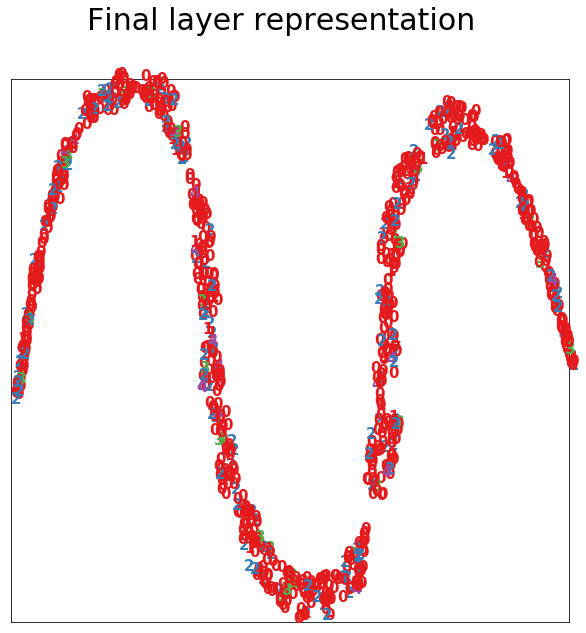

In [4]:
# here insert the TSNET visualization
plot_embedding(t_sne_fit(final_layer, 30), sess.run(images),
                           class_labels,
                           iter, title= "Final layer representation")

Computing t-SNE embedding
time elapsed:25.7822070122


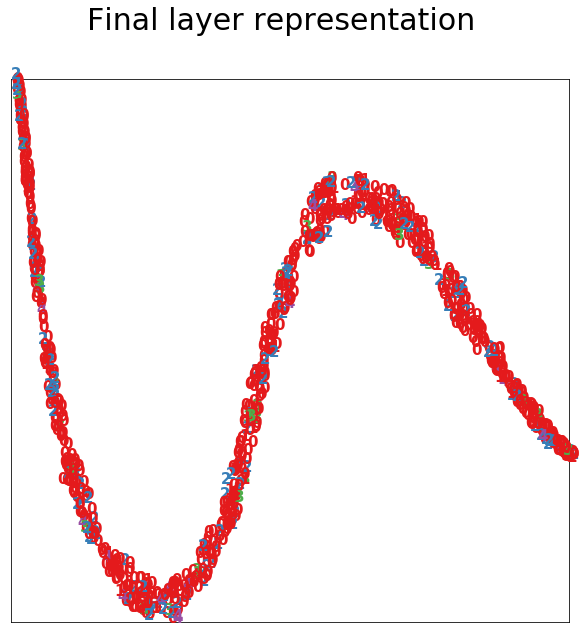

In [5]:
# here insert the TSNET visualization
plot_embedding(t_sne_fit(final_layer, 50), sess.run(images),
                           class_labels,
                           iter, title= "Final layer representation")

Computing t-SNE embedding
time elapsed:37.7758891582


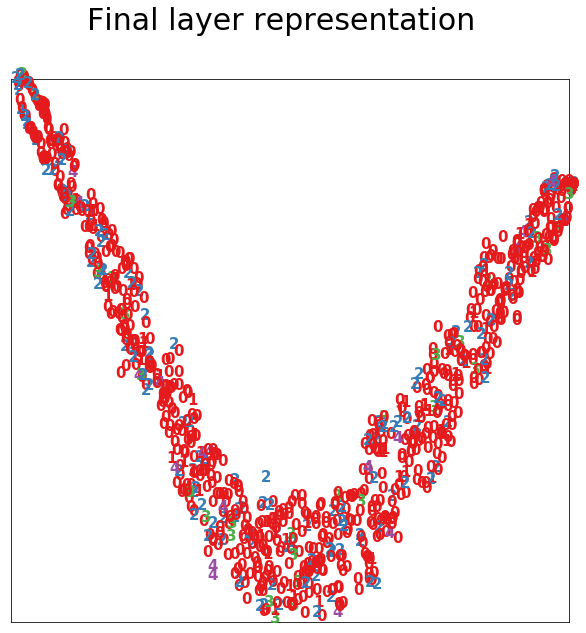

In [6]:
# here insert the TSNET visualization
plot_embedding(t_sne_fit(final_layer, 80), sess.run(images),
                           class_labels,
                           iter, title= "Final layer representation")

Computing t-SNE embedding
time elapsed:45.8790040016


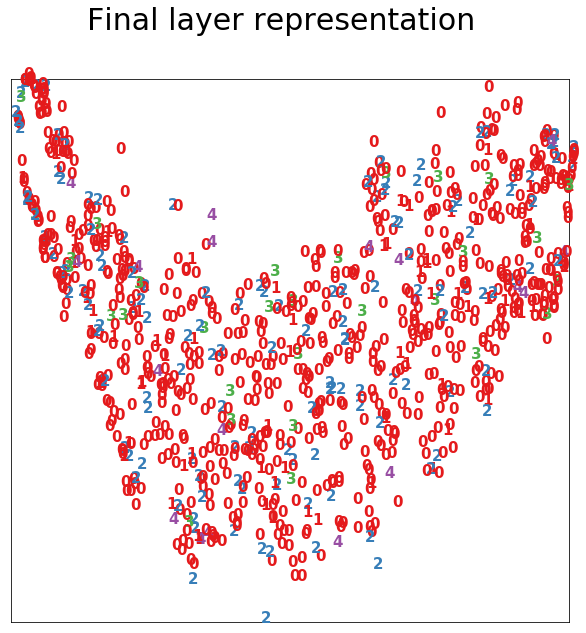

In [7]:
# here insert the TSNET visualization
plot_embedding(t_sne_fit(final_layer, 100), sess.run(images),
                           class_labels,
                           iter, title= "Final layer representation")

Computing t-SNE embedding
time elapsed:49.8866419792


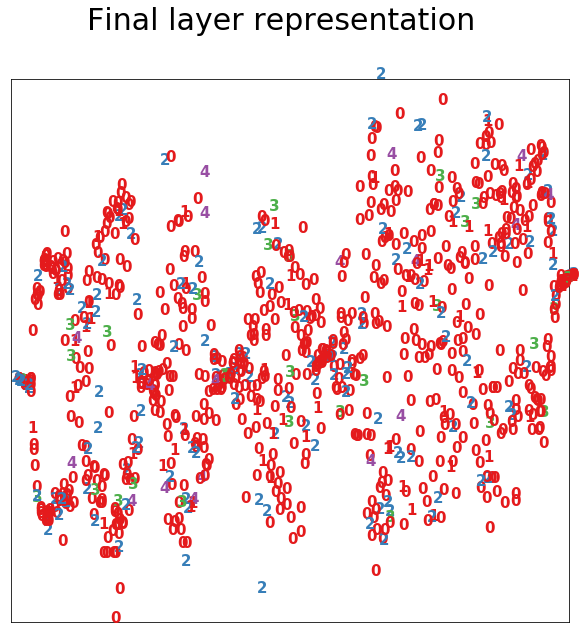

In [9]:
# here insert the TSNET visualization
plot_embedding(t_sne_fit(final_layer, 200), sess.run(images),
                           class_labels,
                           iter, title= "Final layer representation")

One clearly sees that independent of perplexity the model is not capable to discriminate between the classes but simply predict class 0 for all. We implement oversampling and revisit the analysis at a later point